## Module 4.4: Transfer Learning

In this module we will:
- Implement standard transfer learning

Sadly because we want to use a Keras dataset we use very small images that are not really suitable for the advanced pre-trained models Keras has available. So we will not achieve good results!


Start by importing required libraries.

In [11]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Mon Apr 19 11:11:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    39W / 300W |    685MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [33]:
from keras.datasets import cifar10
from keras.applications.densenet import DenseNet121
from keras.applications import ResNet50,ResNet152V2,Xception
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import np_utils, plot_model



We load and pre-process the CIFAR10 data. We use this data as an example only - they are really too small to use with the advanced pre-defined Keras networks, and the results are poor.

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Make versions of the labels that are one-hot vectors
y_train=np_utils.to_categorical(y_train, 10)
y_test=np_utils.to_categorical(y_test, 10)

170500096/170498071 [==============================] - 11s 0us/step


Although you can define your own advanced CNN architecture, it is common to use proven networks. With such networks, it is also possible to load pre-trained weights. These will have been obtained from a large, general image set - such as the imagenet database which currently contains more than 14 million images and 20000 categories. So we would expect that network trained on such data are good and picking out general features from images that could be useful in many tasks, even those containing categories not seen in the training data. We can then use these weights for the feature extraction component of the network, and concentrate on tuning the final classification layers of the network that estimate class probabilities based on extracted features.

Keras provides various pre-defined networks (with pre-trained weights) that make use of the layers we have looked at, including:

Inception Networks:
- InceptionV3

Residual Networks:
- ResNet50
- ResNet101
- ResNet152
- ResNet50V2
- ResNet101V2
- ResNet152V2

Residual Inception Networks:
- InceptionResNetV2

Dense Networks:
- DenseNet121
- DenseNet169
- DenseNet201

We will use DenseNet121 for this example, but you are free to replace it with one of the others.

Let's load the DenseNet121 network architecture with pre-trained weights based on the imagenet dataset.

Note we remove the top, as we will replace the classification component of the network with our own layers and proceed to fine-tune (train) these weights. We also specify the image size we will deal with. Ideally the image size should be similar to the one originally used by the loaded network - too small or large can cause issues (including failure to compile, if dimensionality reduction reduces matrix size to much!). We are using images that are too small for DenseNet121, so will not achieve good results, but will proceed as an example.

In [55]:
base_model=DenseNet121(weights="imagenet",include_top=False,input_shape=(32,32,3))
# base_model=ResNet152V2(weights="imagenet",include_top=False,input_shape=(32,32,3),pooling=None)


29089792/29084464 [==============================] - 0s 0us/step


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.604814 to fit



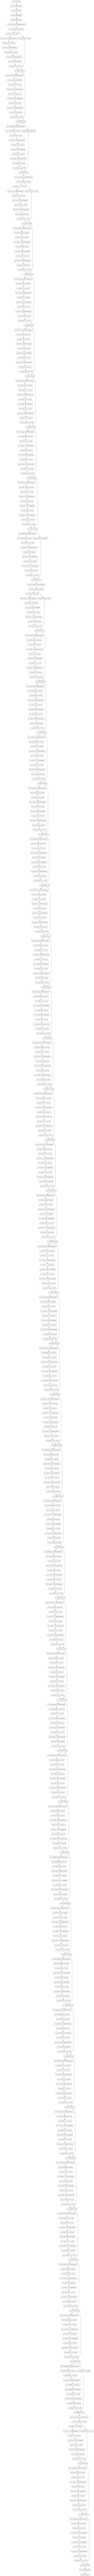

In [36]:
plot_model(base_model)

DenseNet121 has 121 layers. You can look at them in a summary if you desire.

In [56]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 16, 16, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

Now we create a wrapper function that will take our base network and create a custom 'top' to it. This function will also set the weights in the base network (the feature extraction weights) to be not be trained.

In [90]:
def get_final_model(base_model, dropout, class_layers, num_classes):
    # Turn of training for all layers in the base model.
    base_model = Model(inputs=base_model.input,outputs=base_model.get_layer('conv3_block7_concat').output)
    for layer in base_model.layers:
        layer.trainable = False

    # Flatten final layer of network 
    # Remember the classification component (the dense layers and output layer)
    # has been removed. So we are flattening the output of the feature extraction
    # part of the full original network.
    layer = Flatten()(base_model.output)
    
    # Add classification layers, or 'top', to the network 
    # We use dropout regularization
    for nodes in class_layers:
        layer = Dense(nodes, activation='relu')(layer) 
        layer = Dropout(dropout)(layer)

    # Add output layer
    output = Dense(num_classes, activation='softmax')(layer) 

    
    
    final_model = Model(inputs=base_model.input, outputs=output)

    return final_model

Let's get our base model.

In [91]:
final_model = get_final_model(base_model, 
                                      .5, 
                                      [256], 
                                      10)


We compile the network. Feel free to change the optimizer.

In [92]:
final_model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Now we train the network, using early stopping.

In [94]:
final_model.summary()

Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 16, 16, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1/conv[0][0]                 
___________________________________________________________________________________________

In [10]:
#DenseNet121
earlyStopping = EarlyStopping(monitor="val_loss", 
                              patience=10,
                              verbose=1,
                              restore_best_weights=True)

history = final_model.fit(x_train, 
                    y_train, 
                    epochs=100, 
                    shuffle=True,
                    batch_size=2000,
                    callbacks=[earlyStopping],
                    validation_data=(x_test,y_test))

Epoch 1/100
25/25 [==============================] - 10s 188ms/step - loss: 1.1254 - accuracy: 0.6041 - val_loss: 1.0599 - val_accuracy: 0.6270
Epoch 2/100
25/25 [==============================] - 3s 110ms/step - loss: 1.0928 - accuracy: 0.6165 - val_loss: 1.0490 - val_accuracy: 0.6346
Epoch 3/100
25/25 [==============================] - 3s 109ms/step - loss: 1.0779 - accuracy: 0.6234 - val_loss: 1.0442 - val_accuracy: 0.6352
Epoch 4/100
25/25 [==============================] - 3s 109ms/step - loss: 1.0721 - accuracy: 0.6239 - val_loss: 1.0410 - val_accuracy: 0.6346
Epoch 5/100
25/25 [==============================] - 3s 110ms/step - loss: 1.0636 - accuracy: 0.6272 - val_loss: 1.0378 - val_accuracy: 0.6372
Epoch 6/100
25/25 [==============================] - 3s 110ms/step - loss: 1.0607 - accuracy: 0.6271 - val_loss: 1.0360 - val_accuracy: 0.6366
Epoch 7/100
25/25 [==============================] - 3s 109ms/step - loss: 1.0581 - accuracy: 0.6308 - val_loss: 1.0333 - val_accuracy: 0.638

In [95]:
#DenseNet121 mid layer
earlyStopping = EarlyStopping(monitor="val_loss", 
                              patience=10,
                              verbose=1,
                              restore_best_weights=True)

history = final_model.fit(x_train, 
                    y_train, 
                    epochs=200, 
                    shuffle=True,
                    batch_size=5000,
                    callbacks=[earlyStopping],
                    validation_data=(x_test,y_test))

Epoch 1/200
10/10 [==============================] - 3s 156ms/step - loss: 2.0262 - accuracy: 0.2665 - val_loss: 1.1719 - val_accuracy: 0.6305
Epoch 2/200
10/10 [==============================] - 1s 96ms/step - loss: 1.2330 - accuracy: 0.5789 - val_loss: 0.9551 - val_accuracy: 0.6812
Epoch 3/200
10/10 [==============================] - 1s 101ms/step - loss: 1.0234 - accuracy: 0.6504 - val_loss: 0.8636 - val_accuracy: 0.7072
Epoch 4/200
10/10 [==============================] - 1s 97ms/step - loss: 0.9334 - accuracy: 0.6814 - val_loss: 0.8132 - val_accuracy: 0.7248
Epoch 5/200
10/10 [==============================] - 1s 94ms/step - loss: 0.8786 - accuracy: 0.7026 - val_loss: 0.7785 - val_accuracy: 0.7332
Epoch 6/200
10/10 [==============================] - 1s 96ms/step - loss: 0.8340 - accuracy: 0.7154 - val_loss: 0.7576 - val_accuracy: 0.7407
Epoch 7/200
10/10 [==============================] - 1s 98ms/step - loss: 0.8098 - accuracy: 0.7229 - val_loss: 0.7401 - val_accuracy: 0.7439
Epoc

In [18]:
#ResNet50
earlyStopping = EarlyStopping(monitor="val_loss", 
                              patience=10,
                              verbose=1,
                              restore_best_weights=True)

history = final_model.fit(x_train, 
                    y_train, 
                    epochs=300, 
                    shuffle=True,
                    batch_size=5000,
                    callbacks=[earlyStopping],
                    validation_data=(x_test,y_test))

Epoch 1/300
10/10 [==============================] - 7s 318ms/step - loss: 3.1394 - accuracy: 0.1035 - val_loss: 2.2901 - val_accuracy: 0.1307
Epoch 2/300
10/10 [==============================] - 2s 179ms/step - loss: 2.2878 - accuracy: 0.1290 - val_loss: 2.2694 - val_accuracy: 0.1694
Epoch 3/300
10/10 [==============================] - 2s 177ms/step - loss: 2.2726 - accuracy: 0.1381 - val_loss: 2.2507 - val_accuracy: 0.1997
Epoch 4/300
10/10 [==============================] - 2s 179ms/step - loss: 2.2568 - accuracy: 0.1535 - val_loss: 2.2275 - val_accuracy: 0.1947
Epoch 5/300
10/10 [==============================] - 2s 182ms/step - loss: 2.2359 - accuracy: 0.1691 - val_loss: 2.2074 - val_accuracy: 0.2227
Epoch 6/300
10/10 [==============================] - 2s 180ms/step - loss: 2.2196 - accuracy: 0.1796 - val_loss: 2.1794 - val_accuracy: 0.2293
Epoch 7/300
10/10 [==============================] - 2s 179ms/step - loss: 2.1991 - accuracy: 0.1892 - val_loss: 2.1543 - val_accuracy: 0.2620

In [54]:
#ResNet152V2
earlyStopping = EarlyStopping(monitor="val_loss", 
                              patience=10,
                              verbose=1,
                              restore_best_weights=True)

history = final_model.fit(x_train, 
                    y_train, 
                    epochs=300, 
                    shuffle=True,
                    batch_size=5000,
                    callbacks=[earlyStopping],
                    validation_data=(x_test,y_test))

Epoch 1/300
10/10 [==============================] - 6s 273ms/step - loss: 2.7704 - accuracy: 0.1603 - val_loss: 1.8670 - val_accuracy: 0.4211
Epoch 2/300
10/10 [==============================] - 2s 162ms/step - loss: 1.8686 - accuracy: 0.3402 - val_loss: 1.4960 - val_accuracy: 0.5311
Epoch 3/300
10/10 [==============================] - 2s 164ms/step - loss: 1.6336 - accuracy: 0.4176 - val_loss: 1.3503 - val_accuracy: 0.5646
Epoch 4/300
10/10 [==============================] - 2s 166ms/step - loss: 1.4884 - accuracy: 0.4776 - val_loss: 1.2488 - val_accuracy: 0.5945
Epoch 5/300
10/10 [==============================] - 2s 164ms/step - loss: 1.4023 - accuracy: 0.5058 - val_loss: 1.1889 - val_accuracy: 0.6096
Epoch 6/300
10/10 [==============================] - 2s 165ms/step - loss: 1.3471 - accuracy: 0.5304 - val_loss: 1.1410 - val_accuracy: 0.6296
Epoch 7/300
10/10 [==============================] - 2s 165ms/step - loss: 1.3017 - accuracy: 0.5450 - val_loss: 1.0985 - val_accuracy: 0.6362